<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!apt-get -qq install -y tensorflow

Saving kaggle.json to kaggle.json
E: Unable to locate package tensorflow


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 55.8MB/s]
100% 2.29G/2.29G [00:20<00:00, 118MB/s] 


In [ ]:
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

num_classes = 2
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.layers[0].trainable = False

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Path to data
data_dir  = '/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'NORMAL/'
pneumonia_cases_dir = train_dir + 'PNEUMONIA/'

print("Datasets:",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))

Datasets: ['val', 'test', 'train', '.DS_Store']
Train:	 ['NORMAL', 'PNEUMONIA', '.DS_Store']
Test:	 ['NORMAL', 'PNEUMONIA', '.DS_Store']


NORMAL


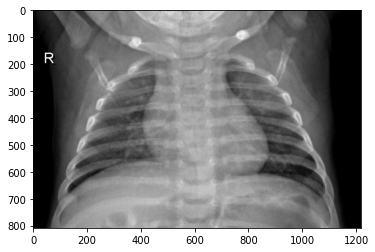

In [ ]:
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img(normal_cases_dir + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


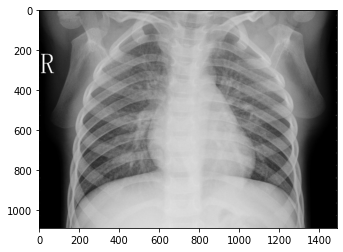

In [ ]:
img_name = 'person1044_virus_1740.jpeg'
img_pneumonia = load_img(pneumonia_cases_dir + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

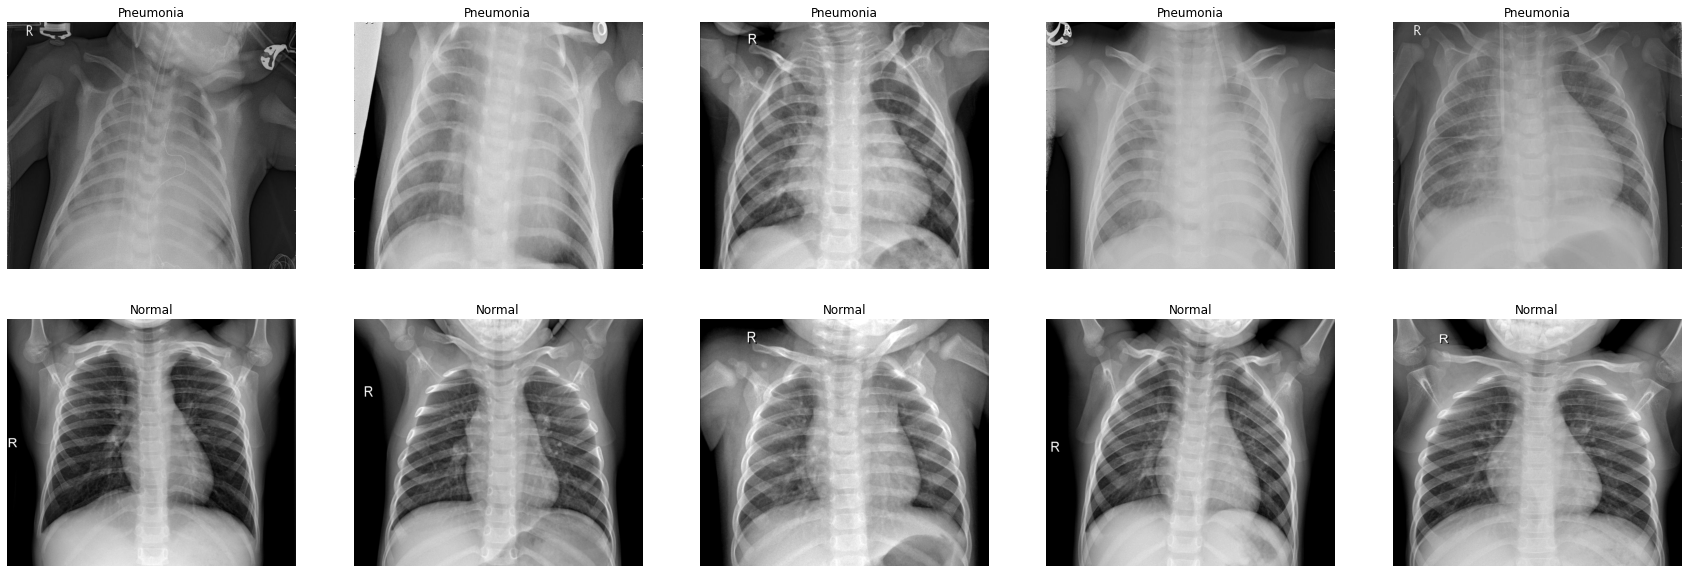

In [ ]:
# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
image_size = 150
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 6
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = '/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/val/',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=validation_generator,# specify where model gets validation data
      callbacks=callbacks_list) 

# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6


InvalidArgumentError: ignored

In [ ]:
model.metrics_names

In [ ]:
from tensorflow.python.keras.models import load_model
#model.save('xray_model.h5')
model = load_model('drive/MyDrive/resnet50.h5')

In [ ]:
model.save("/content/drive/MyDrive/project models/resnet50.h5")

INFO:tensorflow:Assets written to: drive/MyDrive/resnet50/assets


In [ ]:

#nb_samples = test_dir.shape[0]
predict = model.predict_classes(test_generator)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(np.shape(test_generator.classes))

(624,)


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score, acc = model.evaluate(test_generator,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 49s 1s/step - loss: 0.7957 - accuracy: 0.5874
Test score: 0.7746424078941345
Test accuracy: 0.5881410241127014


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('f1 score ',f1_score(y_true=test_generator.classes,y_pred=predict.round(),average='micro'))
print('accuracy ',accuracy_score(predict.round(),test_generator.classes))
print('recall ',recall_score(predict.round(),test_generator.classes,average=None))
print('precision ',precision_score(predict.round(),test_generator.classes,average=None))

f1 score  0.5913461538461539
accuracy  0.5913461538461539
recall  [0.40707965 0.63209393]
precision  [0.1965812  0.82820513]


AUC Value  :  0.5123931623931625


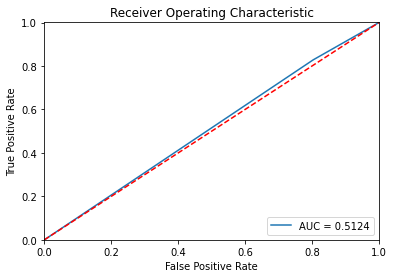

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fprValue2, tprValue2, thresholdsValue2 = roc_curve(test_generator.classes,predict.round())
AUCValue = auc(fprValue2, tprValue2)
print('AUC Value  : ', AUCValue)
plt.title('Receiver Operating Characteristic')
plt.plot(fprValue2, tprValue2, label='AUC = %0.4f'% AUCValue)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

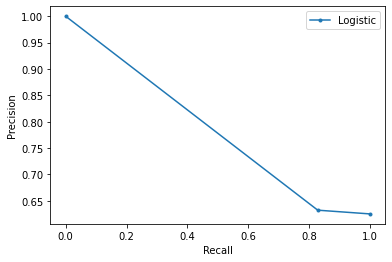

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
precision, recall, _ = precision_recall_curve(test_generator.classes, predict.round())
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

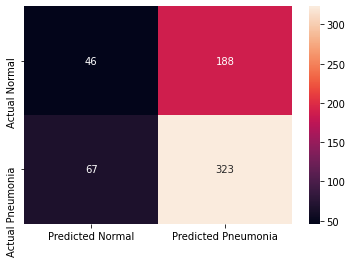

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predict.round()),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
# Accuracy 
'''print(model.history['accuracy'])
plt.plot()
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()'''

TypeError: ignored

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Actual class: NORMAL
Predicted class: Pneumonia
Likelihood: 0.8579


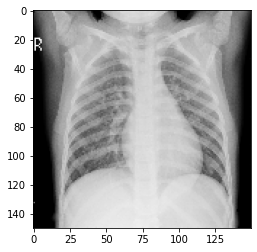

In [ ]:
def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(150, 150))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_class = model.predict_classes(x)
    pred = model.predict(x)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    else:
        print("Predicted class: Pneumonia")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")        
        
choose_image_and_predict()